In [1]:
#Notebook for doing the actual classification

In [1]:
import warnings
warnings.filterwarnings("ignore")
from utils.dataset import AudioDataset, TextDataset, AudioNText
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn
import torch
from utils.model import LSTMnet_RnnAtten
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd

In [2]:
train_annotations = '..\\data\\MELD\\train_sent_emo.csv'
val_annotations = '..\\data\\\MELD\\dev_sent_emo.csv'
test_annotations = '..\\data\\MELD\\test_sent_emo.csv'




train_bert = '..\\text_only\\embeddings\\bert_embeddings'
val_bert = '..\\text_only\\embeddings\\bert_embeddings_val'
test_bert = '..\\text_only\\embeddings\\bert_embeddings_test'

train_audio = '..\\data\\MELD\\audio\\wav\\'
val_audio = '..\\data\\MELD\\audio\\wav_dev\\'
test_audio = '..\\data\\MELD\\audio\\wav_test\\'

In [5]:
em = True
# audio_train = AudioDataset(train_annotations, train_audio, emotion=em)
# audio_val = AudioDataset(val_annotations, val_audio, emotion=em)
audio_test = AudioDataset(test_annotations, test_audio, emotion=em)

# text_train = TextDataset(train_annotations, train_bert, emotion=em)
text_val = TextDataset(val_annotations, val_bert, emotion=em)
text_test = TextDataset(test_annotations, test_bert, emotion=em)




In [5]:
len(text_train), len(audio_train)

(9989, 9988)

In [6]:

train = AudioNText(audio_train, text_train)
val = AudioNText(audio_val, text_val)


batch_size = 64

train_dataloader = DataLoader(train, batch_size=batch_size, shuffle = True, drop_last=False)


train_features, train_labels = next(iter(train_dataloader))


In [7]:
val_dataloader =  DataLoader(val, batch_size=len(val), shuffle = True, drop_last=False)

In [8]:
len(train), len(val)

(9988, 1108)

In [9]:


print(f"audio Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
features = train_features[0]
label = train_labels

features.shape,label

audio Feature batch shape: torch.Size([64, 872])
Labels batch shape: torch.Size([64])


(torch.Size([872]),
 tensor([2, 1, 2, 2, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 2, 0, 1, 1, 2, 0, 0, 1, 1, 2,
         2, 1, 1, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 0, 0, 0, 1, 1, 1, 0, 2,
         2, 1, 1, 2, 0, 2, 2, 2, 2, 1, 1, 0, 2, 1, 2, 2]))

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if em:
    weight=torch.tensor([1-1109/9989, 1-271/9989, 1-268/9989, 1-1743/9989, 1-4710/9989, 1-683/9989, 1-1205/9989]).to(device=device)
else:
    weight=torch.tensor([1-2945/9989, 1-2334/9989, 1-4710/9989]).to(device=device)



In [20]:
def loss_fnc(predictions, targets):
    return nn.CrossEntropyLoss(weight=weight, label_smoothing=0.01)(input=predictions,target=targets)

In [21]:
def make_train_step(model, loss_fnc, optimizer):
    def train_step(X,Y):
        # set model to train mode
        model.train()
        # forward pass
        output_logits = model(X)
        predictions = torch.argmax(output_logits,dim=1)
        accuracy = torch.sum(Y==predictions)/float(len(Y))
        f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
        # compute loss
        loss = loss_fnc(output_logits, Y)
        # compute gradients
        loss.backward()
        # update parameters and zero gradients
        optimizer.step()
        optimizer.zero_grad()
        return loss.item(), accuracy*100 , f1*100
    return train_step

In [22]:
def make_validate_fnc(model,loss_fnc):
    def validate(X,Y):
        with torch.no_grad():
            model.eval()
           
            output_logits = model(X)
            
            predictions = torch.argmax(output_logits,dim=1)
            accuracy = torch.sum(Y==predictions)/float(len(Y))
            f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
            loss = loss_fnc(output_logits,Y)
        return loss.item(), accuracy*100, predictions, f1*100
    return validate

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LSTMnet_RnnAtten(input_dim = 104+768, hidden_dim=256, output_dim=7, num_layers=3, bidirectional=False).to(device)
print('Number of trainable params: ',sum(p.numel() for p in model.parameters()) )
OPTIMIZER = torch.optim.Adam(model.parameters(),lr=0.0001, weight_decay=1e-3)

Number of trainable params:  2606087


In [24]:
train_step = make_train_step(model, loss_fnc, optimizer=OPTIMIZER)
validate = make_validate_fnc(model,loss_fnc)

val_accs = []
losses=[]
val_losses = []
f1s = []
val_f1s= []
epochs = 100
best_val_f1 = 2
j = False

for epoch in range(epochs):
    epoch_acc = 0
    epoch_loss = 0
    epoch_f1 = 0
    for idx, (features, labels) in enumerate(train_dataloader):
        X, Y = features, labels
        X_tensor = torch.tensor(X,device=device).float()
        Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
        loss, acc, f1= train_step(X_tensor,Y_tensor)
        epoch_acc += acc*len(features)/len(train)
        epoch_loss += loss*len(features)/len(train)
        epoch_f1 += f1*len(features)/len(train)
    for batch in val_dataloader:
        X_val, Y_val = batch
        break
    X_val_tensor = torch.tensor(X_val,device=device).float()
    Y_val_tensor = torch.tensor(Y_val,dtype=torch.long,device=device)
    val_loss, val_acc, _, val_f1 = validate(X_val_tensor,Y_val_tensor)
    val_accs.append(val_acc.cpu())
    losses.append(epoch_loss)
    val_losses.append(val_loss)
    f1s.append(epoch_f1)
    val_f1s.append(val_f1)
    if val_f1 > best_val_f1:
        torch.save(model.state_dict(), 'model_parameters/earlyfusion/best-model-parameters_earlyfusion_sent1.pt')
        best_epoch = epoch
        best_val_f1 = val_f1
        j = True
       
    
    print('')
    print(f"Epoch {epoch+1} --> loss:{epoch_loss:.4f}, acc:{epoch_acc:.2f}%, val_loss:{val_loss:.4f}, val_acc:{val_acc:.2f}%  f1:{f1:.2f}%, val_f1:{val_f1:.2f}")
if j:    
    print('saved')


Epoch 1 --> loss:1.1024, acc:39.57%, val_loss:1.0933, val_acc:43.95%  f1:37.50%, val_f1:37.34

Epoch 2 --> loss:1.0965, acc:42.42%, val_loss:1.0958, val_acc:41.88%  f1:73.33%, val_f1:32.23

Epoch 3 --> loss:1.0932, acc:43.35%, val_loss:1.0950, val_acc:43.41%  f1:10.00%, val_f1:33.23

Epoch 4 --> loss:1.0932, acc:43.43%, val_loss:1.0886, val_acc:42.24%  f1:33.33%, val_f1:33.21

Epoch 5 --> loss:1.0916, acc:43.87%, val_loss:1.0927, val_acc:42.69%  f1:37.50%, val_f1:34.41

Epoch 6 --> loss:1.0906, acc:44.50%, val_loss:1.0893, val_acc:44.31%  f1:65.00%, val_f1:34.52

Epoch 7 --> loss:1.0882, acc:44.91%, val_loss:1.0939, val_acc:43.95%  f1:0.00%, val_f1:36.00

Epoch 8 --> loss:1.0883, acc:44.22%, val_loss:1.0861, val_acc:45.85%  f1:75.00%, val_f1:37.74

Epoch 9 --> loss:1.0882, acc:45.39%, val_loss:1.0828, val_acc:44.68%  f1:100.00%, val_f1:38.81

Epoch 10 --> loss:1.0866, acc:45.32%, val_loss:1.0842, val_acc:43.50%  f1:50.00%, val_f1:38.21

Epoch 11 --> loss:1.0871, acc:45.14%, val_loss:1

layers:  3
model hidden dim:  256
batch size:  64
Max f1_val:  45.18525425358174


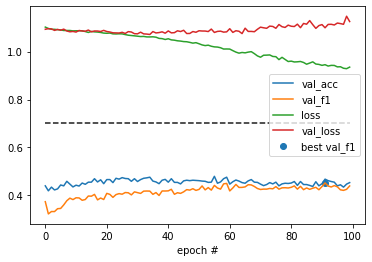

In [28]:

import matplotlib.pyplot as plt
x = range(epochs)

fig, ax = plt.subplots()
ax.set_xlabel('epoch #')
ax.set_ylabel('')
ax.plot(x,np.divide(val_accs,100), label='val_acc')
ax.plot(x,np.divide(val_f1s,100), label='val_f1')
ax.plot(x, losses, label='loss')
ax.plot(x, val_losses, label='val_loss')
ax.scatter(best_epoch, best_val_f1/100, label='best val_f1')
ax.plot(x, 0.7*np.ones(len(x)), '--', color=(0.1,0.1,0.1))
ax.legend()
print("layers: ", model.num_layers)
print("model hidden dim: ", model.hidden_dim)
print("batch size: ", train_dataloader.batch_size)
print("Max f1_val: ", best_val_f1)



In [8]:

model.load_state_dict(torch.load("model_parameters/earlyfusion/best-model-parameters_earlyfusion_emo1.pt"))

<All keys matched successfully>

In [6]:
test = AudioNText(audio_test, text_test)
test_dataloader = DataLoader(test, batch_size=len(test), shuffle=False, drop_last=False)

In [9]:



device = 'cpu'
model.to(device)
f1s = []
f1ss = []

for idx, (features, labels) in enumerate(test_dataloader):
    X, Y = features, labels
    
    X_tensor = torch.tensor(X,device=device).float()
    Y_tensor = torch.tensor(Y, dtype=torch.long,device=device)
    output_logits = model(X)
    predictions = torch.argmax(output_logits,dim=1)
   
    f1 = f1_score(Y.cpu(), predictions.cpu(), average='weighted')
    f1_ = f1_score(Y.cpu(), predictions.cpu(), average=None, labels=[0,1,2,3,4,5,6])
    f1s.append(f1)
    f1ss.append(f1_)

print(f1)
print(f1_)
# emotions = {'anger':0, 'disgust':1, 'fear':2, 'joy':3, 'neutral':4, 'sadness':5, 'surprise':6}
#  emotions = {'negative':0, 'positive':1, 'neutral':2}

0.35446762583454694
[0.23622047 0.         0.         0.10204082 0.60957179 0.00913242
 0.125     ]
